- Choose a topic in classification (such as: brand classification, cosmetic classification, traditional costumes classification, healthy and unhealthy dishes classification...) => apply CNN to build a model to classify class of each sample.
## Note:
- Create dataset (like dog/cat dataset): with at least 2 classes, each class has at least 2000 training samples, 500 testing samples)

## Note:
* Nguồn data lấy từ https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images/code?datasetId=2707450
* Tuy nhiên không đủ số lượng hình ảnh theo yêu cầu, vì vậy, số lượng data còn thiếu được lấy từ google
* File code cào dữ liệu: Image Scraping.ipynb

In [1]:
from keras.applications import VGG16, vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras import regularizers
from keras.applications import EfficientNetB5, efficientnet
from keras.applications import ResNet50, resnet
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
# %cd '/content/gdrive/MyDrive/DATA SCIENCE - ĐH KHTN/LDS8 - Deep Learning/FinalTest'
%cd '/content/gdrive/MyDrive/Deep Learning'

/content/gdrive/MyDrive/Deep Learning


In [4]:
# !unzip -q '/content/gdrive/MyDrive/DATA SCIENCE - ĐH KHTN/LDS8 - Deep Learning/FinalTest/Data.zip'

# Load image

In [5]:
# from traitlets.traitlets import validate
# # Image generator for training data and v
# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     zoom_range=0.2,
#     shear_range=0.2,
#     validation_split=0.2,
#     #preprocessing_function=preprocess_input
# )

# test_datagen = ImageDataGenerator(rescale=1./255) #preprocessing_function=preprocess_input)

In [6]:
# # Create training and validation generators
# train_generator = train_datagen.flow_from_directory(
#     'Landscape/Training Data',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     subset='training'
# )

# validation_generator = train_datagen.flow_from_directory(
#     'Landscape/Training Data',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'
# )

# test_generator = test_datagen.flow_from_directory(
#     'Landscape/Testing Data',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary'
# )

In [7]:
train_dir = 'Landscape/Training Data'
test_dir = 'Landscape/Testing Data'

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [8]:
# New version of TensorFlow (2.10+)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.Rescaling(1./255) # normalize the image
], name="data_augmentation")

In [9]:
seed_train_validation = 1 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.2

train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       label_mode="binary",
                                                       image_size=IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       validation_split=validation_split,
                                                       subset='training',
                                                       shuffle = shuffle_value,
                                                       seed = seed_train_validation)

val_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                       label_mode="binary",
                                                       image_size=IMAGE_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       validation_split=validation_split,
                                                       subset='validation',
                                                       shuffle = shuffle_value,
                                                       seed = seed_train_validation)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="binary",
                                                                 image_size=IMAGE_SHAPE,
                                                                 batch_size=BATCH_SIZE)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.
Found 1000 files belonging to 2 classes.


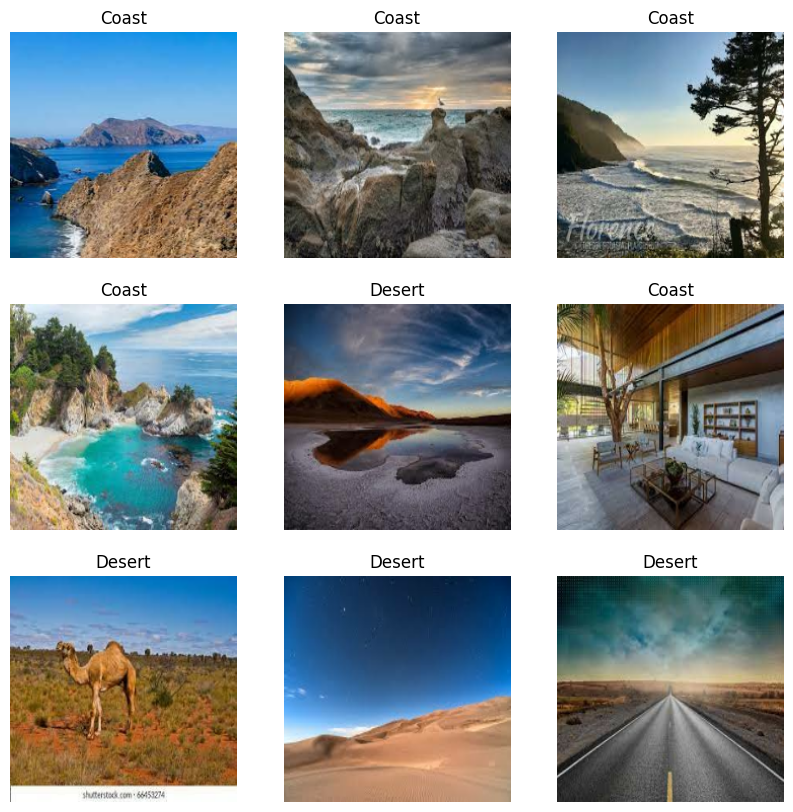

In [10]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    labels = np.array(labels)
    labels = labels.reshape(-1).astype("uint8")
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create a CNN model

In [11]:
# Create a CNN model using Keras' Sequential API
model = Sequential([
    # First convolutional layer with 32 nodes, 3x3 filters, and relu activation function
    Conv2D(filters=64, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu', padding='same', strides=1),

    # Second convolutional layer with 32 nodes, 3x3 filters, and relu activation function
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', strides=1),

    # Max pooling layer with 2x2 pool size
    MaxPooling2D(pool_size=(2, 2)),

    # Dropout layer with 0.2 dropout rate
    Dropout(rate=0.2),

    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 ),

    # Third convolutional layer with 64 nodes, 3x3 filters, and relu activation function
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides=1),

    # Fourth convolutional layer with 64 nodes, 3x3 filters, and relu activation function
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', strides=1),

    # Max pooling layer with 2x2 pool size
    MaxPooling2D(pool_size=(2, 2)),

    # Dropout layer with 0.2 dropout rate
    Dropout(rate=0.2),

    # Flatten layer
    Flatten(),

    # Fully connected layer with 128 nodes and relu activation function
    Dense(units=64, activation='relu'),

    # Fully connected layer with 128 nodes and relu activation function
    Dense(units=32, activation='relu'),

    # Fully connected layer with 128 nodes and relu activation function
    Dense(units=16, activation='relu'),

    # Fully connected layer with 128 nodes and relu activation function
    Dense(units=8, activation='tanh'),

    # Output layer with 1 node and sigmoid activation function
    Dense(units=1, activation='sigmoid')
])

In [12]:
# View the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      1

In [13]:
# Compile the model
model.compile(Adamax(learning_rate= 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
# Use model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'model_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True
)

In [15]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [16]:
start_time = datetime.now()
print(f'Training started at {start_time}')

# Train the model
history = model.fit(
    train_data,
    epochs=200,
    validation_data=val_data,
    callbacks=[early_stopping],
    workers= 6,   # Number of CPU processes to use for parallelizing data preprocessing and augmentation
    verbose=1
)

end_time = datetime.now()
print(f'Training ended at {end_time}')

Training started at 2023-06-24 12:30:37.022156
Epoch 1/200
100/100 [==============================] - 36s 200ms/step - loss: 0.6757 - accuracy: 0.5387 - val_loss: 0.6676 - val_accuracy: 0.7375
Epoch 2/200
100/100 [==============================] - 20s 198ms/step - loss: 0.6505 - accuracy: 0.8128 - val_loss: 0.6406 - val_accuracy: 0.8125
Epoch 3/200
100/100 [==============================] - 20s 199ms/step - loss: 0.6221 - accuracy: 0.8559 - val_loss: 0.6179 - val_accuracy: 0.8275
Epoch 4/200
100/100 [==============================] - 20s 198ms/step - loss: 0.6002 - accuracy: 0.8606 - val_loss: 0.6160 - val_accuracy: 0.7788
Epoch 5/200
100/100 [==============================] - 21s 203ms/step - loss: 0.5931 - accuracy: 0.8247 - val_loss: 0.6455 - val_accuracy: 0.6712
Epoch 6/200
100/100 [==============================] - 20s 199ms/step - loss: 0.5045 - accuracy: 0.8419 - val_loss: 0.4483 - val_accuracy: 0.8400
Epoch 7/200
100/100 [==============================] - 21s 203ms/step - loss:

In [17]:
print('Time spent:', end_time-start_time)

Time spent: 0:10:32.271832


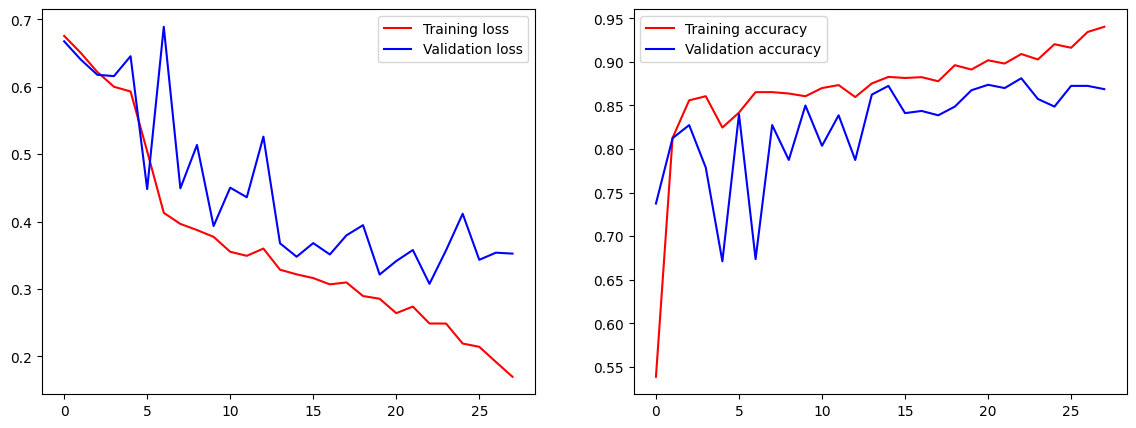

In [18]:
# Draw the loss and accuracy curves of the training set and the validation set
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Draw the loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.legend()

# Draw the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.legend()

plt.show()

In [19]:
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

32/32 [==============================] - 358s 8s/step - loss: 0.2768 - accuracy: 0.8940
Test accuracy : 0.8939999938011169


### Confusion matrix of Batch test

In [20]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

predictions = tf.where(predictions < 0.5, 0, 1)
predictions = predictions.numpy()
predictions = predictions.reshape(-1)

label_batch = np.array(label_batch)
label_batch = label_batch.reshape(-1).astype("uint8")

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

Predictions:
 [1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1]
Labels:
 [1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1]


Train report               precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.87      0.76      0.81        17

    accuracy                           0.81        32
   macro avg       0.82      0.82      0.81        32
weighted avg       0.82      0.81      0.81        32

Train conf matrix [[13  2]
 [ 4 13]]


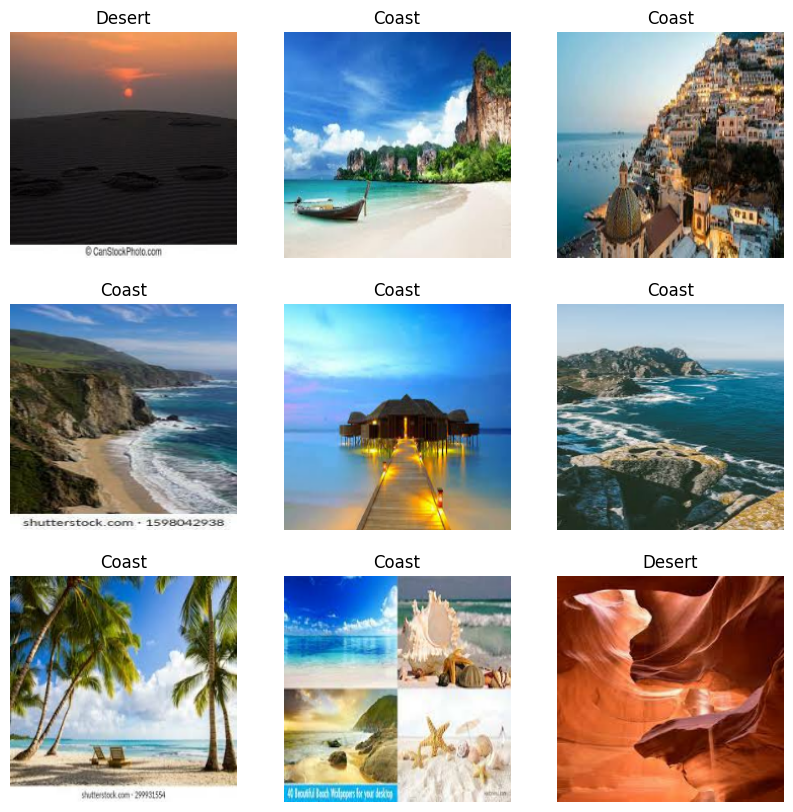

In [21]:
print('Train report', classification_report(label_batch, predictions))
print('Train conf matrix', confusion_matrix(label_batch, predictions))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

### Confusion matrix of test_data

In [22]:
pred_classes = model.predict(test_data)
pred_classes = tf.where(pred_classes < 0.5, 0, 1)
pred_classes = pred_classes.numpy()
pred_classes = pred_classes.reshape(-1)

print(pred_classes[:10])

test_unbatch = test_data.unbatch()
test_labels = []
for (image,label) in test_unbatch:
    test_labels.append(label)

print(test_labels[:10])

print('Train report', classification_report(test_labels, pred_classes))
print('Train conf matrix', confusion_matrix(test_labels, pred_classes))


32/32 [==============================] - 2s 53ms/step
[1 0 1 0 1 1 0 1 1 0]
[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>]
Train report               precision    recall  f1-score   support

         0.0       0.48      0.52      0.50       500
         1.0       0.48      0.45      0.46       500

    ac

## Nhận xét:
* Mô hình mất khoảng 10 phút để train
* Accuracy của model là ~89% tuy nhiên accuracy sau khi áp dụng confusion matrix chỉ ~81%.
* Accuracy sau khi áp dụng dụ đoán cho tất cả ảnh của tập test chỉ đạt 48%, chênh lệch rất lớn với accuracy của batch.
* Có hiện tượng overfit khi huấn luyện mô hình.
* Loss và accuracy của validation không ổn định trong quá trình huấn luyện.